## Read eddy tracks from pyeddytracker output (or AVISO obs) and plot

In [15]:
import os
import os.path
import glob

import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [16]:
eddy_types = ['cyclonic', 'anticyclonic']
# filter tracks to only have eddies that live this long
min_lifetime_tracks = 365
suites = ['aviso']
# limit the years read to this
years_max = [2013]
model_names = ['AVISO']

file_all = {}
file_all['anticyclonic'] = "/gws/nopw/j04/eerie/model_derived_data/EERIE/MOHC/GC5-MM/eddy_tracks/Anticyclonic_tracks.nc"
file_all['cyclonic'] = "/gws/nopw/j04/eerie/model_derived_data/EERIE/MOHC/GC5-MM/eddy_tracks/Cyclonic_tracks.nc"
file_obs = {}
file_obs['anticyclonic'] = "/gws/nopw/j04/eerie/observations/AVISO/META3.2_DT_allsat_Anticyclonic_long_19930101_20220209.nc"
file_obs['cyclonic'] = "/gws/nopw/j04/eerie/observations/AVISO/META3.2_DT_allsat_Cyclonic_long_19930101_20220209.nc"


In [17]:
def load_data(fname, year_max, suite, min_lifetime=None):
    # Load dataset with xarray
    dataset = xr.open_dataset(fname)
    print('times ',suite, dataset["time.year"])

    total_tracks, count = np.unique(dataset.track, return_counts=True)
    print('total eddies ', len(count))

    # Bounds of the area
    lon_min, lon_max, lat_min, lat_max = 0, 360, -70, 70
    #lon_min, lon_max, lat_min, lat_max = 0, 20, -60, -50

    # Select all observation in the area
    #subset_1993 = dataset.sel(dataset.time=slice('2001-01-01', '2002-01-01'))
    if min_lifetime is not None:
        subset_lifetime1 = dataset.sel(obs=dataset.observation_number > min_lifetime)
        subset_lifetime = dataset.isel(obs=np.in1d(dataset.track, subset_lifetime1.track))
    else:
        subset_lifetime = dataset

    if year_max != '':
        subset_time = subset_lifetime.sel(
            obs=(subset_lifetime.latitude > lat_min) & (subset_lifetime.latitude < lat_max) & (subset_lifetime["time.year"] <= year_max))
    else:
        subset_time = subset_lifetime.sel(
            obs=(subset_lifetime.latitude > lat_min) & (subset_lifetime.latitude < lat_max))

    total_tracks, count = np.unique(subset_time.track, return_counts=True)
    print('total eddies constrained by year and lifetime ', len(count))
    print('years subset ', subset_time["time.year"])
    #subset.to_netcdf(file_1993)

    # Create a mask with all the trajectories passing through the area
    # Create the subset with the mask
    #subset = dataset.isel(obs=np.in1d(dataset.track, subset.track))

    # Find all the trajectories which are longer than min_lifetime days
    #if min_lifetime is not None:
    #    subset_lon_life = subset.sel(obs=subset.observation_number > min_lifetime)
    #    subset = subset.isel(obs=np.in1d(subset.track, subset_lon_life.track))
    #else:
    #    subset = subset.isel(obs=np.in1d(subset.track, subset.track))

    #subset = subset_time.isel(obs=np.in1d(subset_time.track, subset_time.track))
    subset = subset_time

    return subset


In [18]:
def read_datafiles(suites, min_lifetime):
    eddy_subset = {}
    for isu, suite in enumerate(suites):
        #subset, subset_lon_life = load_data(file_all['cyclonic'], year_max)
        #plot_birth(subset, proj, ax)

        for ie, eddy_t in enumerate(eddy_types):
            if suite == 'aviso':
                file_in = file_obs
            else:
                file_in = file_all
            subset = load_data(file_in[eddy_t].format(suite), years_max[isu], suite, min_lifetime=min_lifetime)
            #unique, counts = np.unique(subset.track, return_counts=True)
            eddy_subset[(suite, eddy_t)] = subset
    return eddy_subset

In [19]:
def plot_tracks_per_model(subset, ntracks, eddy_type, fig, ax, proj, nfig, nyears, suite, isu, min_lifetime):
    if eddy_type == 'cyclonic':
        colour = 'blue'
    else:
        colour = 'red'
    # Plot selected data
    ax.scatter(
        subset.longitude,
        subset.latitude,
        #c=subset.track,
        c=colour,
        s=0.1,
        transform=proj,
        linewidth=0.,
        cmap='tab20b',
        rasterized=True)

    # Add title
    if nfig == 0:
        ax.set_title(" Trajectories longer than "+str(min_lifetime)+" days over "+str(nyears)+' years, '+model_names[isu], fontsize=10)
    if eddy_type == 'cyclonic':
        ax.text(60, 55, 'C: '+str(ntracks), c = colour)
    else:
        ax.text(60, 45, 'A: '+str(ntracks), c = colour)
    # Active meridian/parallel
    if nfig == 0:
        ax.gridlines(draw_labels=True)
    # Active coastline
    ax.coastlines()
    # Display figure
    #plt.savefig('./'+suite+'_'+str(year_max)+'_'+str(min_lifetime)+'.png')


In [20]:
eddy_subset = read_datafiles(suites, min_lifetime = min_lifetime_tracks)

times  aviso <xarray.DataArray 'year' (obs: 36522562)>
array([1993, 1993, 1993, ..., 2022, 2022, 2022])
Dimensions without coordinates: obs
total eddies  854856
total eddies constrained by year and lifetime  1959
years subset  <xarray.DataArray 'year' (obs: 985724)>
array([1993, 1993, 1993, ..., 2013, 2013, 2013])
Dimensions without coordinates: obs
times  aviso <xarray.DataArray 'year' (obs: 34521490)>
array([1993, 1993, 1993, ..., 2022, 2022, 2022])
Dimensions without coordinates: obs
total eddies  805895
total eddies constrained by year and lifetime  2337
years subset  <xarray.DataArray 'year' (obs: 1209406)>
array([1993, 1993, 1993, ..., 2013, 2013, 2013])
Dimensions without coordinates: obs


In [21]:
def plot_tracks(suites, eddy_subset, min_lifetime):
    # Projection
    proj=ccrs.PlateCarree()
    # Create figure
    nsuites = len(suites)
    if nsuites == 1:
        fig = plt.figure(figsize=(10,5),dpi=100)
        ny = 1; nx = 1
    elif nsuites == 2:
        fig = plt.figure(figsize=(10,10),dpi=100)
        ny = 1; nx = 2
    else:
        fig = plt.figure(figsize=(15,10),dpi=100)
        ny = 2; nx = 2

    for isu, suite in enumerate(suites):
        # Create subplot
        ax = fig.add_subplot(nx, ny, isu+1, projection=proj)

        for ie, eddy_t in enumerate(eddy_types):
            subset = eddy_subset[(suite, eddy_t)]
            years = subset["time.year"].values
            months = subset["time.month"].values
            nyears = years[-1] - years[0]
            print('years, nyears ', suite, years, nyears)

            # Create the final subset
            # print('subset.track ',subset.track)
            unique, counts = np.unique(subset.track, return_counts=True)
            ntracks = len(counts)
            print('No tracks ', ntracks)
            plot_tracks_per_model(subset, ntracks, eddy_t, fig, ax, proj, ie, nyears, suite, isu, min_lifetime)

    fig.subplots_adjust(bottom=0.07, left=0.12, right=.9, top=.9, wspace=0.2, hspace=0.26)
    plt.tight_layout()
    figname = './eddy_tracks_' + '_'.join(suites) + '_minlen_' + str(min_lifetime)
    plt.savefig(figname + '.pdf')
    plt.savefig(figname + '.png')
    plt.show()


### Plotting eddy tracks

years, nyears  aviso [1993 1993 1993 ... 2013 2013 2013] 20
No tracks  1959
years, nyears  aviso [1993 1993 1993 ... 2013 2013 2013] 20
No tracks  2337


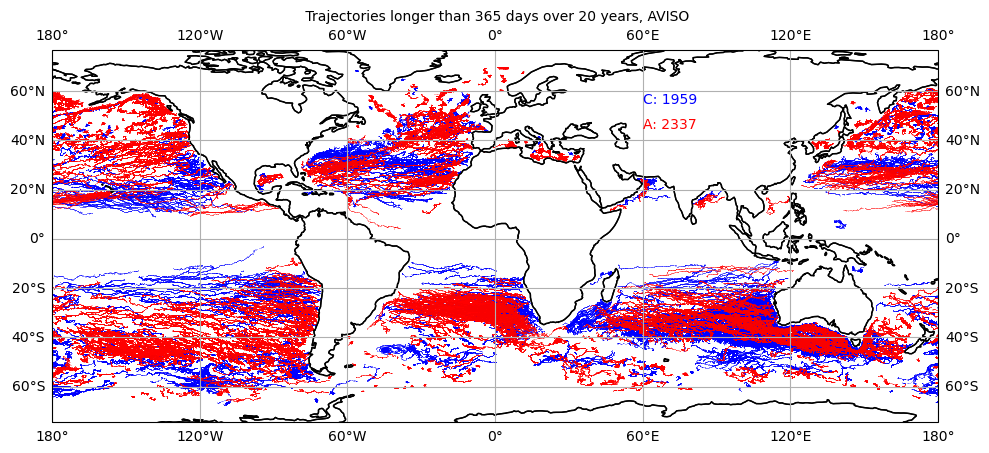

In [22]:
plot_tracks(suites, eddy_subset, min_lifetime_tracks)